In [3]:
# !pip install torchcam
# !pip install segmentation-models-pytorch
# !pip install segmentation-models-pytorch torch torchvision
# !pip install shap scikit-image 

import torch
import torchvision.transforms as T
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import numpy as np 
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.2/997.2 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 54.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 32.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 32.8 MB/s eta 0:00:0000:0100:01


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 7
model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=num_classes)

checkpoint = torch.load("/home/pnaray2s/workspace/Learnings/Xai/sss/my_checkpoints/H1_Experiments/data_processed_citypark_25m_H1_Experiments_citypark_synthetic_25m_pretrained_unet_unet_miou0.5013_epoch60_best.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)

class_names = checkpoint.get("class_names", None)
    
model.to(device)
model.eval()

/tmp/ipykernel_869185/20790957.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/pnaray2s/workspace/Learnings/Xai/sss/my_checkpoints/H1_Expe

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [7]:
import torch.nn.functional as F

def predict_fn(images_np):
    # shape [N, H, W, 3]
    inputs = torch.from_numpy(images_np.transpose(0,3,1,2)).float()
    with torch.no_grad():
        outputs = model(inputs)
        # for UNet-like output
        if isinstance(outputs, torch.Tensor):
            logits = outputs
        elif isinstance(outputs, dict) and 'logits' in outputs:
            logits = outputs['logits']
        else:
            raise ValueError("Unknown model output format")
        probs = F.softmax(logits, dim=1)  # [N, 7, H, W]
        # get mean class probabilities
        mean_probs = probs.mean(dim=(2,3)).cpu().numpy()  # [N, 7]
        return mean_probs

In [1]:
import torch
import torchvision.transforms as T
from torchcam.methods import GradCAM
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import numpy as np 
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 7
model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=num_classes)

checkpoint = torch.load("/home/pnaray2s/workspace/Learnings/Xai/sss/my_checkpoints/H1_Experiments/data_processed_citypark_25m_H1_Experiments_citypark_synthetic_25m_pretrained_unet_unet_miou0.5013_epoch60_best.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)

class_names = checkpoint.get("class_names", None)
    
model.to(device)
model.eval()

image_path = "/home/pnaray2s/workspace/Learnings/Xai/sss/datasets/final/citypark/data_processed_citypark_25m/test/Images/scene_2014.jpeg"

transform = T.Compose([T.Resize((512, 512)),T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

original = cv2.imread(image_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(original)

input_tensor = transform(pil_image).unsqueeze(0).to(device)


/home/pnaray2s/miniconda3/envs/sss/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1586906/2070174731.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start set

/tmp/ipykernel_1597134/51207750.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


Running SHAP for class 0 pooled probability...


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


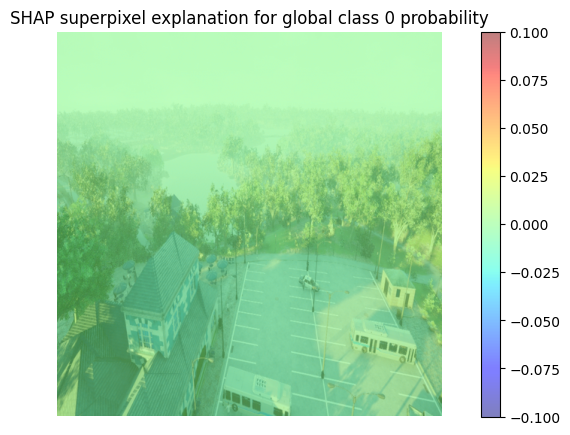

In [23]:
import torch
import segmentation_models_pytorch as smp
import torchvision.transforms as T
from PIL import Image
import numpy as np
from skimage.segmentation import slic
import shap
import matplotlib.pyplot as plt

# --- 1. Load UNet ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 7
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=num_classes
)
checkpoint = torch.load(
    "/home/pnaray2s/workspace/Learnings/Xai/sss/my_checkpoints/H1_Experiments/data_processed_citypark_25m_H1_Experiments_citypark_synthetic_25m_pretrained_unet_unet_miou0.5013_epoch60_best.pth",
    map_location=device
)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# --- 2. Load and preprocess image ---
image_path = "/home/pnaray2s/workspace/Learnings/Xai/sss/datasets/final/citypark/data_processed_citypark_25m/test/Images/scene_2014.jpeg"
pil_image = Image.open(image_path).convert("RGB").resize((512,512))
original_image = np.array(pil_image) / 255.0

# --- 3. superpixels ---
segments = slic(original_image, n_segments=50, compactness=10, start_label=0)
num_superpixels = np.max(segments) + 1

# --- 4. predict function for global pooled probabilities ---
def predict_global(zs):
    images = []
    for z in zs:
        masked = original_image.copy()
        for sp in range(num_superpixels):
            if z[sp] == 0:
                masked[segments == sp] = 0.5  # gray out
        images.append(masked)
    images = np.array(images)

    images_torch = torch.tensor(images.transpose(0,3,1,2)).float()
    # normalize
    for t in images_torch:
        t[0] = (t[0]-0.485)/0.229
        t[1] = (t[1]-0.456)/0.224
        t[2] = (t[2]-0.406)/0.225
    images_torch = images_torch.to(device)
    with torch.no_grad():
        outputs = model(images_torch)
        probs = torch.softmax(outputs, dim=1)
        pooled = probs.mean(dim=(2,3)).cpu().numpy()  # [n_samples, 7]
    return pooled

# --- 5. background
background = np.ones((1, num_superpixels))

# --- 6. SHAP for class 0 pooled ---
explainer = shap.KernelExplainer(
    lambda z: predict_global(z)[:,0],
    background
)

print("Running SHAP for class 0 pooled probability...")
shap_values = explainer.shap_values(background, nsamples=100)
sp_shap_values = shap_values[0]

# --- 7. visualize ---
heatmap = np.zeros(segments.shape)
for sp in range(num_superpixels):
    heatmap[segments == sp] = sp_shap_values[sp]

# stretch contrast
vmin = np.percentile(sp_shap_values, 5)
vmax = np.percentile(sp_shap_values, 95)

plt.figure(figsize=(10,5))
plt.imshow(original_image)
im = plt.imshow(heatmap, cmap="jet", alpha=0.5, vmin=vmin, vmax=vmax)
plt.colorbar(im)
plt.title(f"SHAP superpixel explanation for global class 0 probability")
plt.axis("off")
plt.show()


In [5]:
!pip show shap

Name: shap
Version: 0.48.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: 
Author: 
Author-email: Scott Lundberg <slund1@cs.washington.edu>
License: MIT License
Location: /home/pnaray2s/miniconda3/envs/sss/lib/python3.9/site-packages
Requires: cloudpickle, numba, numpy, packaging, pandas, scikit-learn, scipy, slicer, tqdm, typing-extensions
Required-by: 


Per super pixel explaination 

/tmp/ipykernel_1597134/1569885976.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


Explaining influence on target superpixel 10 for class 0


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


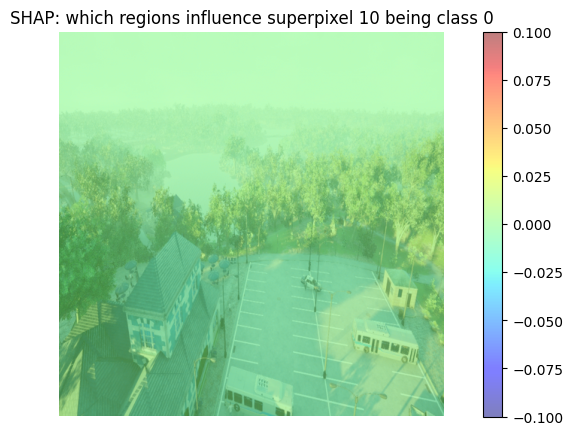

Explaining influence on target superpixel 10 for class 1


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


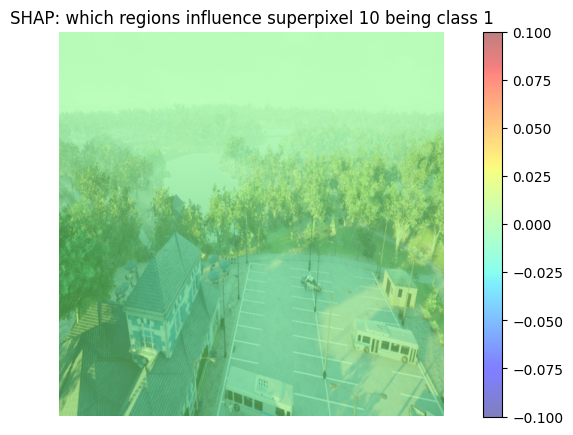

Explaining influence on target superpixel 10 for class 2


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


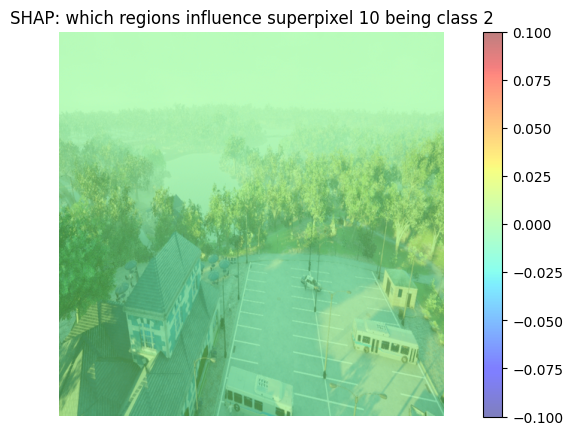

Explaining influence on target superpixel 10 for class 3


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


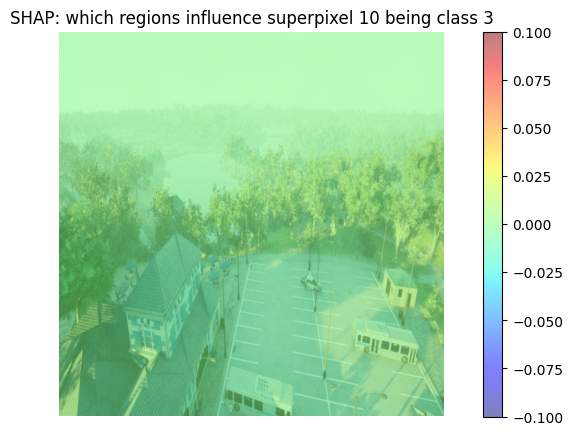

Explaining influence on target superpixel 10 for class 4


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


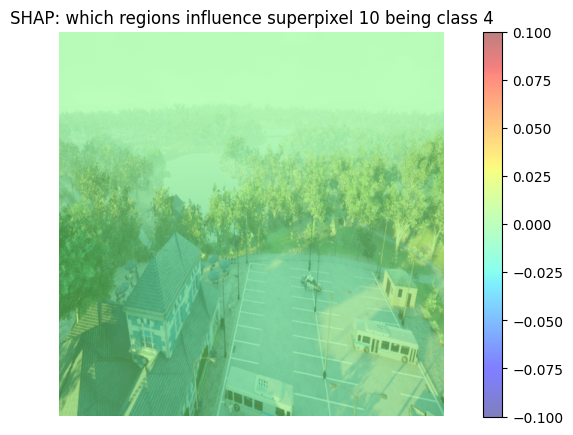

Explaining influence on target superpixel 10 for class 5


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


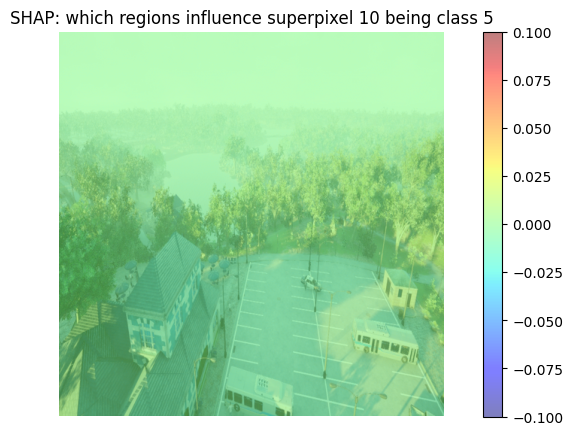

Explaining influence on target superpixel 10 for class 6


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


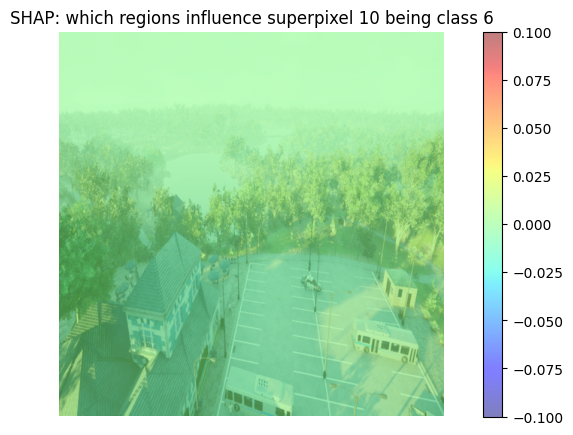

In [22]:
import torch
import segmentation_models_pytorch as smp
import torchvision.transforms as T
from PIL import Image
import numpy as np
from skimage.segmentation import slic
import shap
import matplotlib.pyplot as plt

# --- 1. Load UNet model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 7
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=num_classes
)
checkpoint = torch.load(
    "/home/pnaray2s/workspace/Learnings/Xai/sss/my_checkpoints/H1_Experiments/data_processed_citypark_25m_H1_Experiments_citypark_synthetic_25m_pretrained_unet_unet_miou0.5013_epoch60_best.pth",
    map_location=device
)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# --- 2. Load image and resize ---
image_path = "/home/pnaray2s/workspace/Learnings/Xai/sss/datasets/final/citypark/data_processed_citypark_25m/test/Images/scene_2014.jpeg"
pil_image = Image.open(image_path).convert("RGB").resize((512,512))
original_image = np.array(pil_image) / 255.0

# --- 3. Segment the image into superpixels ---
segments = slic(original_image, n_segments=50, compactness=10, start_label=0)
num_superpixels = np.max(segments) + 1

# pick which superpixel to explain
target_sp = 10  # you can change this

# --- 4. Define the prediction function for SHAP ---
def predict_superpixelwise(zs, target_superpixel_id):
    images = []
    for z in zs:
        masked = original_image.copy()
        for sp in range(num_superpixels):
            if z[sp] == 0:
                masked[segments == sp] = 0.5  # gray out
        images.append(masked)
    images = np.array(images)

    images_torch = torch.tensor(images.transpose(0,3,1,2)).float()
    # normalize
    for t in images_torch:
        t[0] = (t[0]-0.485)/0.229
        t[1] = (t[1]-0.456)/0.224
        t[2] = (t[2]-0.406)/0.225
    images_torch = images_torch.to(device)
    with torch.no_grad():
        outputs = model(images_torch)
        probs = torch.softmax(outputs, dim=1)
        # average only on the target superpixel region
        mask = (segments == target_superpixel_id)
        pooled = probs[:, :, mask].mean(dim=2).cpu().numpy()  # [n_samples, num_classes]
    return pooled

# background: all superpixels present
background = np.ones((1, num_superpixels))

# --- 5. Explain with SHAP ---
for class_idx in range(7):
    print(f"Explaining influence on target superpixel {target_sp} for class {class_idx}")
    explainer = shap.KernelExplainer(
        lambda z: predict_superpixelwise(z, target_sp)[:,class_idx],
        background
    )
    shap_value = explainer.shap_values(background, nsamples=100)

    sp_shap_values = shap_value[0]

    # visualize
    heatmap = np.zeros(segments.shape)
    for sp in range(num_superpixels):
        heatmap[segments==sp] = sp_shap_values[sp]

    # rescale for better visibility
    vmin = np.percentile(sp_shap_values, 5)
    vmax = np.percentile(sp_shap_values, 95)

    plt.figure(figsize=(10,5))
    plt.imshow(original_image)
    im = plt.imshow(heatmap, cmap="jet", alpha=0.5, vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"SHAP: which regions influence superpixel {target_sp} being class {class_idx}")
    plt.axis("off")
    plt.show()
